In [26]:
!pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=95478b373fcdc92bbd4a86c547564f2b2773dc0189bbc9f96f1cd7f8439152e5
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [1]:
pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [2]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.9 MB/s eta 0:00:00


In [3]:
#Libraries helping with file retrival
import os
from os import listdir
from os.path import isfile, join

#Visualization and data manipulation libraries
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import butter, lfilter
import mne
import pandas as pd
import numpy as np
#import antropy
import seaborn as sns
sns.set(font_scale=1.2)

#Model development and understanding
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score

In [4]:
%load_ext watermark

In [5]:
%watermark --iversions

seaborn   : 0.13.1
pandas    : 1.5.3
scipy     : 1.11.4
matplotlib: 3.7.1
mne       : 1.6.1
numpy     : 1.25.2



In [6]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

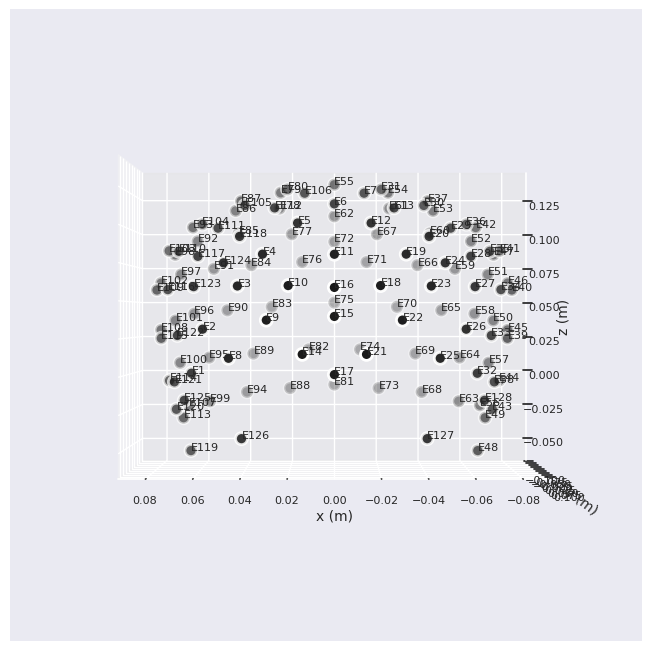

In [7]:
#Function to import the dataset, make some cleanups and return the data
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

#Visualize the Montage positions
fig = montage.plot(kind='3d',scale_factor = 10)

In [43]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')

def file_importer(path="02010002erp 20150416 1131.raw",type=1):
  """
  Inputs:
  path = Location of the raw file
  type = 1 / 0 indicating raw or mat format
  Outputs:
  Returns the .raw object for EEG
  """
  if type == 1:
    df = mne.io.read_raw_egi(path,verbose=True)
    #Delete the bad signal that we identified
    df.drop_channels('E129')
    #Just set the montage - Though the research institution provided us the montage file,
    #there are numerous challenges importing the file as the matlab native format is not set in the
    #mne package. As a result, we will be utilizing make_standard_montage file present in the mne library --
    #As the machine that was used is related to 'GSN_HydroCel-129'. However, kindly ensure that we are
    #deleting the dead signal E129
  else:
    ch_names = ['E'+str(i+1) for i in range(128)]
    sampling_freq = 250
    mat = scipy.io.loadmat(path)
    key = list(mat.keys())
    data = key[3]
    a_mat = mat[data]
    info = mne.create_info(ch_names= ch_names,
                       ch_types='eeg', verbose=None,
                       sfreq=sampling_freq)
    df = mne.io.RawArray(a_mat[:-1,:], info)

  df.set_montage(montage)
  #df = df.pick_channels(ch_names = list(Electrode_map.values()))
  df.plot_psd()
  return df

Reading EGI header from /content/02010002erp 20150416 1131.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {SESS} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


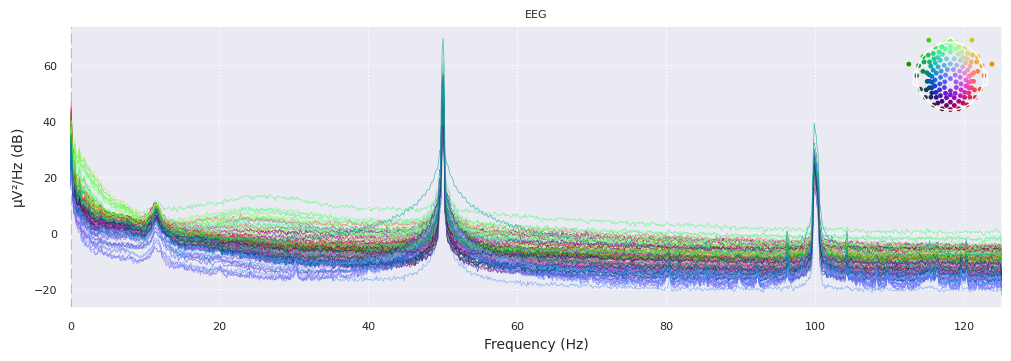

In [44]:
raw_erp = file_importer()

In [32]:
Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}

#Electrodes to pick
list(Electrode_map.values())

['E36',
 'E104',
 'E24',
 'E124',
 'E33',
 'E122',
 'E22',
 'E9',
 'E70',
 'E83',
 'E52',
 'E92',
 'E45',
 'E108',
 'E58',
 'E96']

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


<ipython-input-33-87df75157dd8>:1: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  raw_erp.pick_channels(list(Electrode_map.values())).plot_psd()


Effective window size : 8.192 (s)


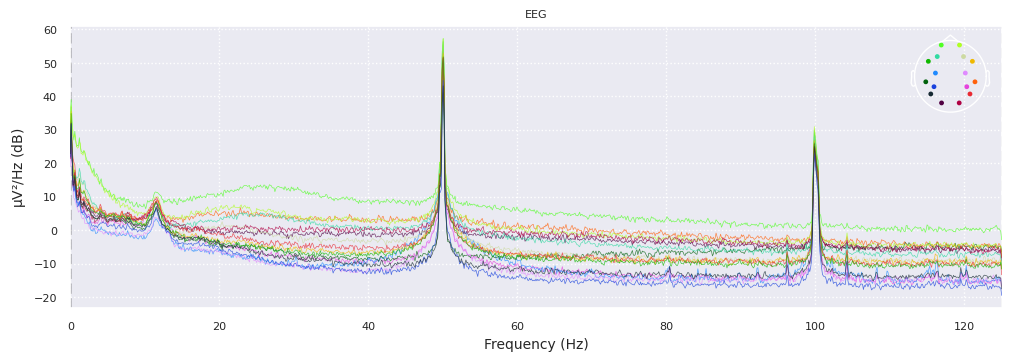

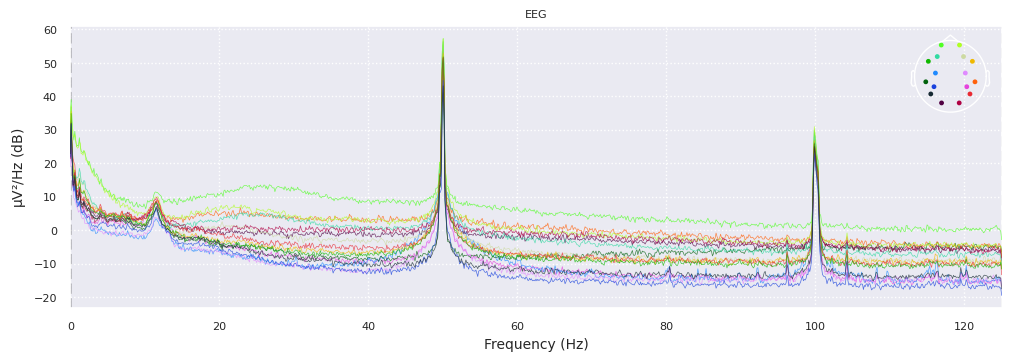

In [33]:
raw_erp.pick_channels(list(Electrode_map.values())).plot_psd()

Initial Power Distribution
After Filtering- Power Distribuition
Reading 0 ... 197401  =      0.000 ...   789.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


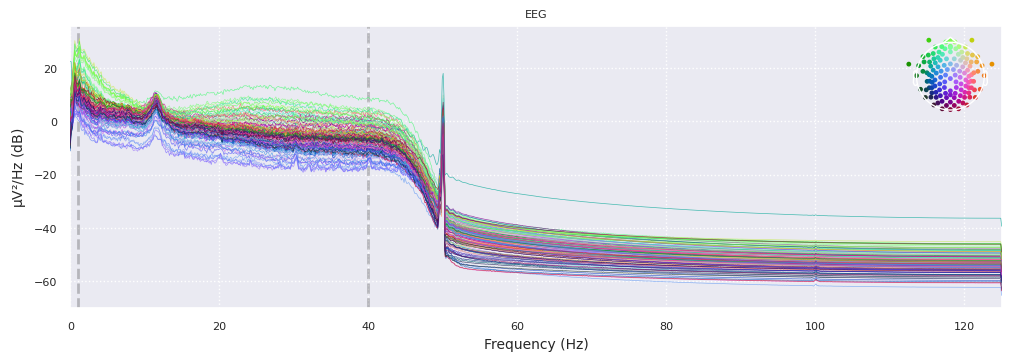

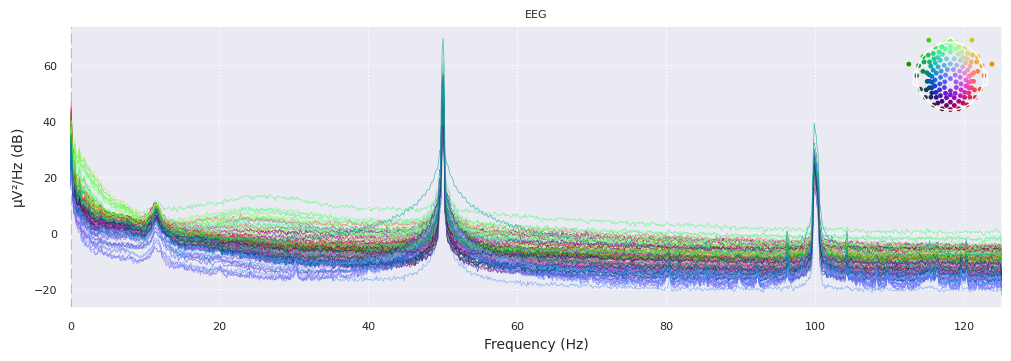

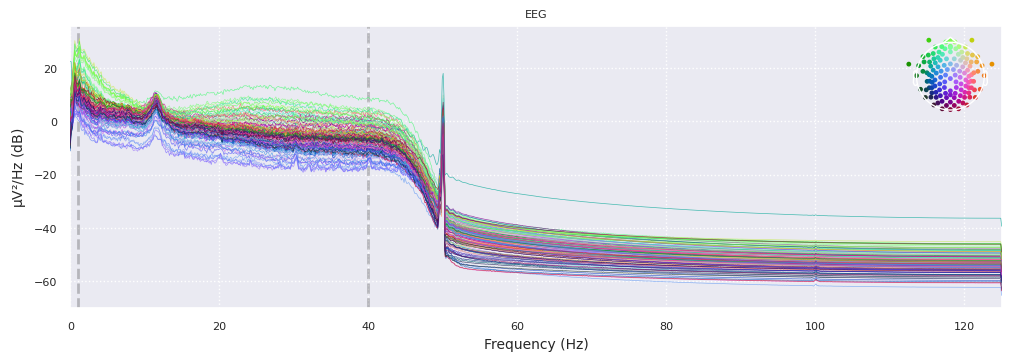

In [45]:
sampling_freq = 250
# Butter Bandpass Filter from 1-50 Hz
l_freq = 1
h_freq = 40

def raw_trunc(stimulated_raw):
    stimulated_raw=stimulated_raw.copy().load_data()
    stimulated_raw_trunc = stimulated_raw.filter(l_freq,h_freq,method='fir', fir_window='hamming')
    return stimulated_raw_trunc

print("Initial Power Distribution")
print("After Filtering- Power Distribuition")
raw_trunct=raw_trunc(raw_erp)
raw_erp.plot_psd()
raw_trunct.plot_psd()

In [46]:
def butter_bandpass_filter(data):
  """
  Inputs :
  data -Raw eeg data
  lowcut-low pass frequency
  highcut-high pass frequency
  fs-sampling frequenct
  Order - Order at which filter needs to be designed
  Outputs:
  y - Filtered signal
  """
  fs = 256                                # Sampling rate (256 Hz)
  eeg_bands = {'Delta':(1,4),
               'Theta': (4, 8),
               'Alpha': (8, 12),
               'Beta': (12, 30),
               'Gamma': (30, 45),
               'Normal':(0,40)}
  # Get real amplitudes of FFT (only in postive frequencies)
  fft_vals = np.absolute(np.fft.rfft(data))
  # Get frequencies for amplitudes in Hz
  fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

  # Take the mean of the fft amplitude for each EEG band
  eeg_band_mean = dict()
  eeg_band_median = dict()
  eeg_band_max = dict()
  eeg_band_min = dict()
  eeg_band_fft = dict()
  for band in eeg_bands:
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &
                      (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    eeg_band_median[band] = np.median(fft_vals[freq_ix])
    eeg_band_mean[band] = np.mean(fft_vals[freq_ix])
    eeg_band_max[band] = np.max(fft_vals[freq_ix])
    eeg_band_min[band] = np.min(fft_vals[freq_ix])

  return eeg_band_mean,eeg_band_median,eeg_band_max,eeg_band_min,eeg_band_fft

In [47]:
def signal_extractor(df, prefix):
    d=df.get_data()
    ch_names=df.ch_names
    val_dict=dict()
    for i in np.arange(d.shape[0]):
        data=d[i,:]
        eeg_band_mean,eeg_band_median,eeg_band_max,eeg_band_min,eeg_band_fft = butter_bandpass_filter(data)
        mean = eeg_band_mean['Normal']
        max = eeg_band_max['Normal']
        min = eeg_band_min['Normal']
        median = eeg_band_median['Normal']
        alpha = eeg_band_fft['Alpha']
        beta = eeg_band_fft['Beta']
        delta = eeg_band_fft['Delta']
        theta = eeg_band_fft['Theta']
        objects = [alpha, beta, delta, theta, mean,max,min,median]
        val_dict[ch_names[i]] = objects

    result=pd.DataFrame(val_dict).T
    result.columns = ['lf_alpha_'+prefix,'lf_beta_'+prefix,'lf_delta_'+prefix,'lf_theta_'+prefix,'lf_mean_'+prefix,'lf_max_'+prefix,'lf_min_'+prefix,'lf_median_'+prefix]
    return result

In [48]:
signal_extractor(raw_erp, 'one_pat').head()

,lf_alpha_one_pat,lf_beta_one_pat,lf_delta_one_pat,lf_theta_one_pat,lf_mean_one_pat,lf_max_one_pat,lf_min_one_pat,lf_median_one_pat
E1,0.009197,0.004703,0.029170,0.011922,0.020509,126.454099,0.000036,0.004709
E2,0.008355,0.004442,0.030665,0.010765,0.056791,1315.108658,0.000027,0.004451
E3,0.010076,0.006516,0.041635,0.014003,0.090575,2109.456340,0.000040,0.006722
E4,0.010546,0.005984,0.041639,0.014799,0.040119,526.747381,0.000038,0.006238
E5,0.010841,0.005423,0.044506,0.016488,0.054184,884.714861,0.000066,0.005555


In [ ]:
import python_entropy as ent

SystemError: initialization of _internal failed without raising an exception

In [ ]:
dir(ent)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [49]:
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
#from .utils import _embed

In [17]:
def _embed(x, order=3, delay=1):

    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[(i * delay):(i * delay + Y.shape[1])]
    return Y.T

In [18]:
def perm_entropy(x, order=3, delay=1, normalize=False):

    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


In [19]:
def spectral_entropy(x, sf, method='welch', nperseg=None, normalize=False,axis=-1):
    x = np.asarray(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf, axis=axis)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se

In [20]:
def svd_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e

In [50]:
def nli_features(df, prefix):
    ch_names=df.ch_names
    val_dict=dict()
    overall = raw_trunc(df.copy())
    d = overall.get_data()

    for i in range(d.shape[0]):
        signal = d[i,:]
        svdentropy = svd_entropy(signal, normalize=True)
        spectralentropy = spectral_entropy(signal, sf=250, method='welch', normalize=True)
        permentropy = perm_entropy(d[i,:], normalize=True)

        objects = [svdentropy,spectralentropy,permentropy]
        val_dict[ch_names[i]]=objects

    result = pd.DataFrame(val_dict).T

    result.columns = ['nl_svden_'+prefix, 'nl_spec_en'+prefix, 'nl_permen'+prefix]
    return result


In [51]:
nli_features(raw_erp, 'one_pat').head()

Reading 0 ... 197401  =      0.000 ...   789.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


,nl_svden_one_pat,nl_spec_enone_pat,nl_permenone_pat
E1,0.472424,0.490312,0.783087
E2,0.460892,0.467293,0.778375
E3,0.574941,0.546001,0.803617
E4,0.598420,0.585663,0.826692
E5,0.576004,0.600490,0.819386


In [52]:
Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}

#Electrodes to pick
list(Electrode_map.values())

['E36',
 'E104',
 'E24',
 'E124',
 'E33',
 'E122',
 'E22',
 'E9',
 'E70',
 'E83',
 'E52',
 'E92',
 'E45',
 'E108',
 'E58',
 'E96']

In [38]:
import antropy as ant

In [39]:
#Non Linear Features
def nli_features(df,prefix):
  """
  Input:
  df - .raw object : EEG Waveform data
  prefix - It is used to name the columns
  Output:
  returns 'result'. It is a pandas dataframe with dimensions 149*2 (128 electrodes
  +21 event trigger stim channels (More details to follow) each having 2 features)
  """
  ch_names = df.ch_names
  val_dict = dict()
  overall = raw_trunc(df.copy())
  d = overall.get_data()
  # Extract Non Linear features
  for i in range(d.shape[0]):
    signal = d[i,:]
    svd_entropy = ant.svd_entropy(signal, normalize=True)
    spectral_entropy = ant.spectral_entropy(signal, sf=250, method='welch', normalize=True)
    perm_entropy = ant.perm_entropy(d[i,:], normalize=True)
    #app_entropy = ant.app_entropy(d[i,:])
    #sample_entropy = ant.sample_entropy(d[i,:])

    #objects = [svd_entropy,spectral_entropy,perm_entropy,app_entropy,sample_entropy]
    objects = [svd_entropy,spectral_entropy,perm_entropy]
    val_dict[ch_names[i]] = objects
  result = pd.DataFrame(val_dict).T
  #result.columns = ['nl_svden_'+prefix,'nl_spec_en'+prefix,'nl_permen'+prefix,'nl_appen'+prefix,'nl_sampen'+prefix]
  result.columns = ['nl_svden_'+prefix,'nl_spec_en'+prefix,'nl_permen'+prefix]
  return result

In [40]:
nli_features(raw_erp, 'one_pat').head()

Reading 0 ... 197401  =      0.000 ...   789.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



,nl_svden_one_pat,nl_spec_enone_pat,nl_permenone_pat
E9,0.518671,0.482325,0.799280
E22,0.652255,0.617834,0.799924
E24,0.664979,0.673491,0.799062
E33,0.550543,0.605777,0.781289
E36,0.579393,0.620631,0.837357


In [41]:
Electrode_map = {'C3':'E36','C4':'E104','F3':'E24','F4':'E124','F7':'E33','F8':'E122',
                 'FP1':'E22','FP2':'E9','O1':'E70','O2':'E83','P3':'E52','P4':'E92',
                 'T3-T7':'E45','T4-T8':'E108','T5-P7':'E58','T6-P8':'E96'}
Electrode_understanding = {'Left-Central':'E36','Right-Central':'E104','Front-Left':'E24','Front-Right':'E124',
                           'Front-Far left':'E33','Front-Far Right':'E122',
                           'Forehead (above left eye)':'E22','Forehead (above Right eye)':'E9',
                           'Back-left to Center':'E70','Back-Right to Center':'E83','Back-Above E70':'E52',
                           'Back-Above E83':'E92','Side Left':'E45','Side Right':'E108','Left':'E58','Right':'E96'}

#Electrodes to pick
list(Electrode_map.values())

['E36',
 'E104',
 'E24',
 'E124',
 'E33',
 'E122',
 'E22',
 'E9',
 'E70',
 'E83',
 'E52',
 'E92',
 'E45',
 'E108',
 'E58',
 'E96']

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


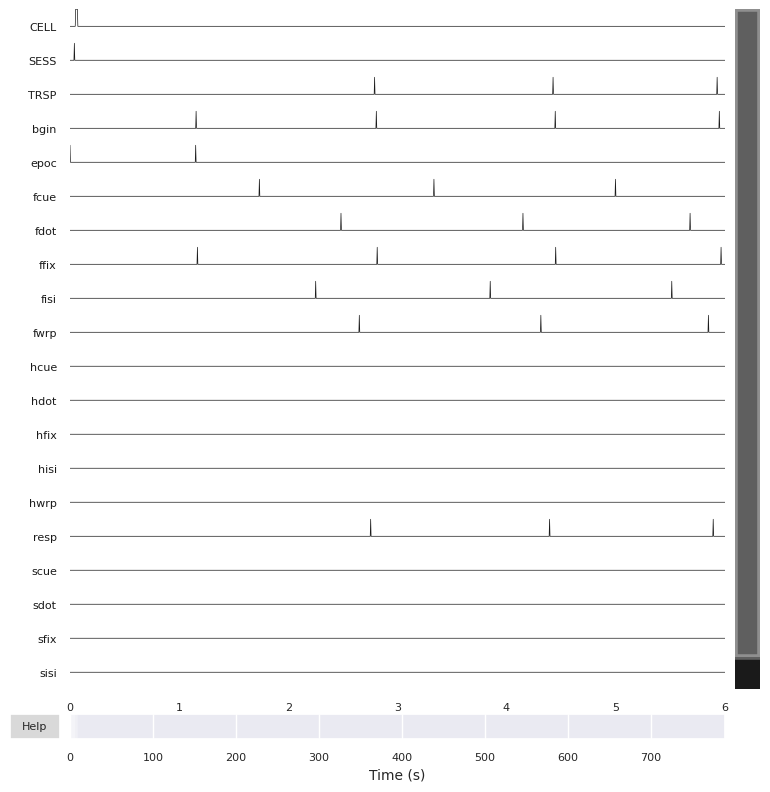

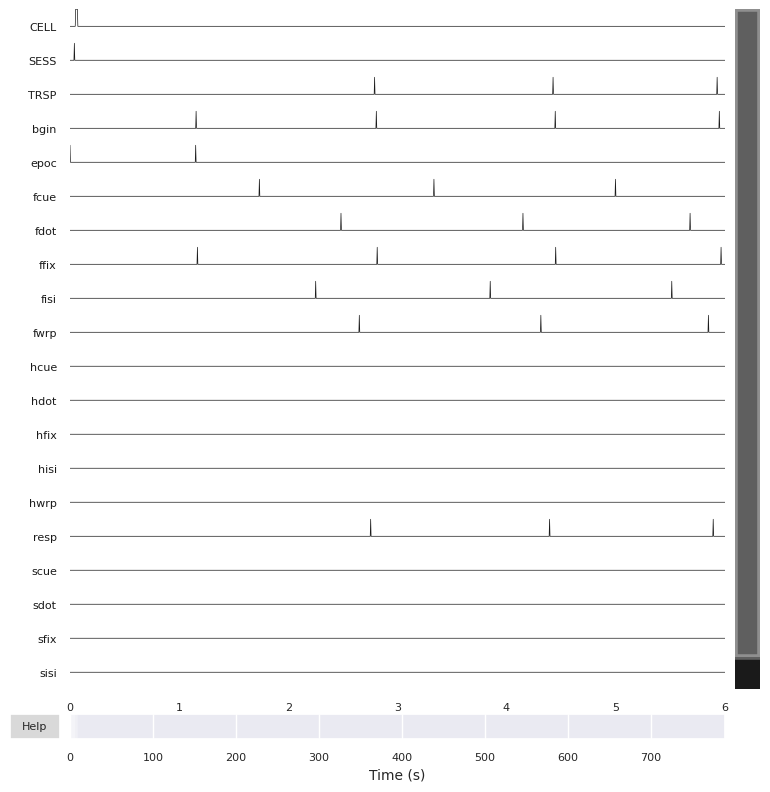

In [53]:
raw_erp.copy().pick_types(meg=False, stim=True).plot(start=0, duration=6)

In [ ]:
print(raw_erp.annotations.description)

[]
